In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('', os.pardir)))
analysis_dir = os.path.abspath(os.path.join('', os.pardir))
sys.path.insert(0, os.path.abspath(os.path.join(analysis_dir, os.pardir)))
from utils.misc import read_json_file
from src.ml.helper.utils import parse_traces_config

analysis_dir = os.path.abspath(os.path.join('', os.pardir))
root_dir = os.path.abspath(os.path.join(analysis_dir, os.pardir))
root_dir

ml_dir: /home/lorenzo/Desktop/research-projects/mimic-2/src/ml | src_dir: /home/lorenzo/Desktop/research-projects/mimic-2/src | entry_dir: /home/lorenzo/Desktop/research-projects/mimic-2 




'/home/lorenzo/Desktop/research-projects/mimic-2'

In [2]:
# Get config

# Select policy
policy = "adaptive_greedy_threshold"

log_dir_path = os.path.join(root_dir, 'log')
mab_dir_path = os.path.join(log_dir_path, 'mab', 'config')
config_file_name = policy + '.json'
file_path = os.path.join(mab_dir_path, config_file_name)
config = read_json_file(file_path)

# Get model timestamp
model_name = config["models"][0]['name']
model_ts = '.'.join(model_name.split('.')[1:])
model_ts

'2023.03.22.14.39.27'

In [3]:
# Read trace names and paths from YAML file
trace_data = parse_traces_config()
traces = [t for t in trace_data['traces'].keys()]
traces

['att.lte.driving',
 'att.lte.driving.2016',
 'tm.lte.driving',
 'tm.lte.short',
 'tm.umts.driving',
 'vz.evdo.driving',
 'vz.lte.driving',
 'vz.lte.short',
 'bus',
 'timessquare',
 'wired']

In [4]:
import re
from datetime import datetime

# Get iperf config
def get_config(tag):
    iperf_test_dir_path = os.path.join(log_dir_path, 'iperf')
    ts_list = []
    latest_timestamp = None

    for config_file in os.listdir(iperf_test_dir_path):
        if config_file.startswith(tag):
            full_path = os.path.join(iperf_test_dir_path, config_file)
            # print(config_file)
            pattern = r"\d{4}\.\d{2}\.\d{2}\.\d{2}\.\d{2}\.\d{2}"
            match = re.search(pattern, config_file)
            if not match:
                continue
            timestamp_str = match.group(0)
            timestamp = datetime.strptime(timestamp_str, "%Y.%m.%d.%H.%M.%S")
            ts_list.append(timestamp)
            # check if this timestamp is more recent
            if latest_timestamp is None or timestamp > latest_timestamp:
                latest_timestamp = timestamp
                mimic_config_file = full_path
    return mimic_config_file

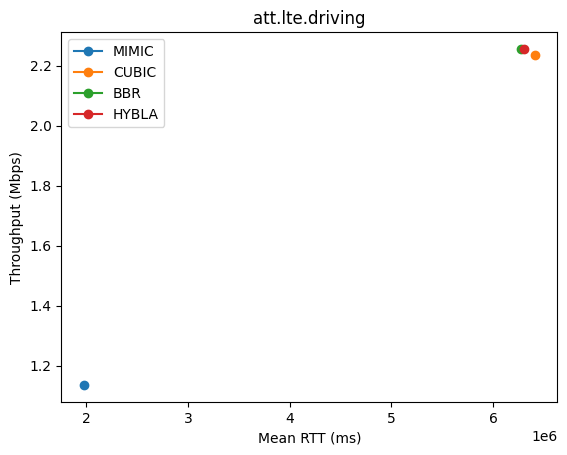

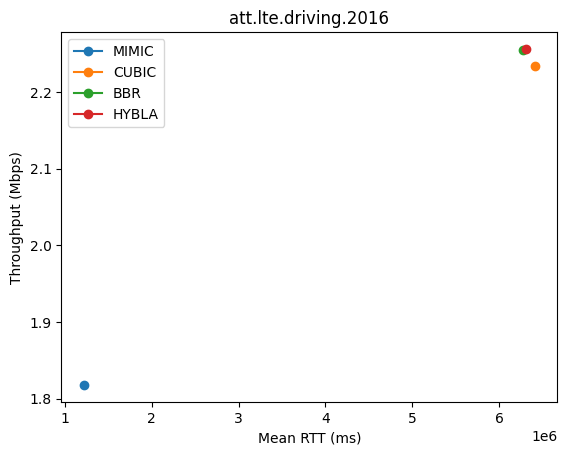

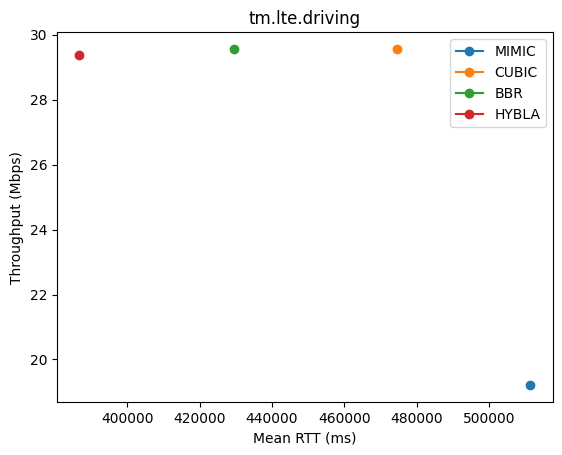

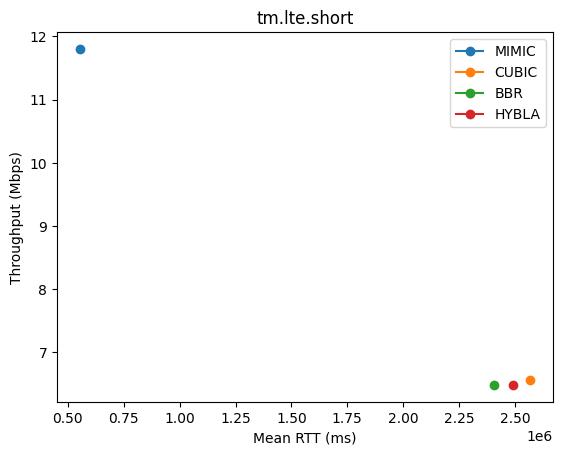

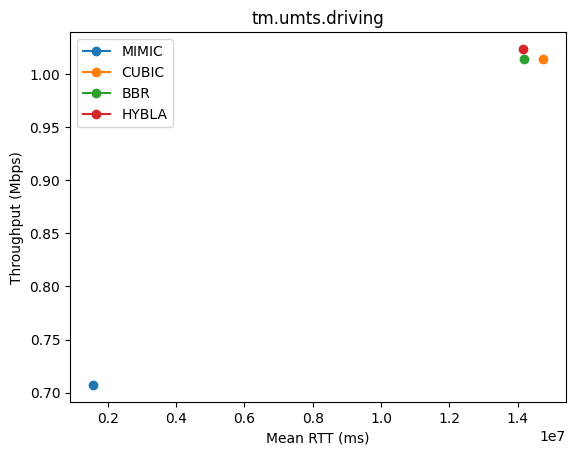

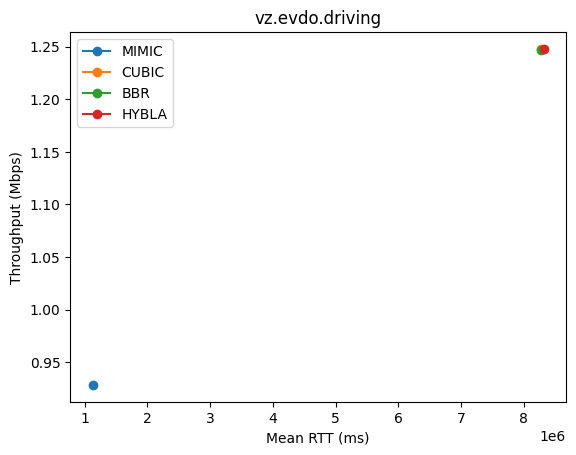

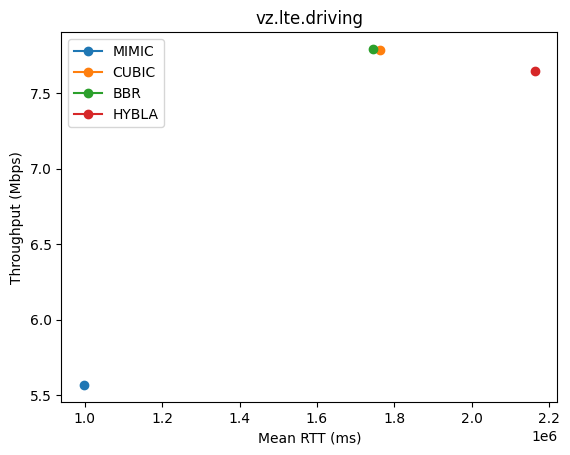

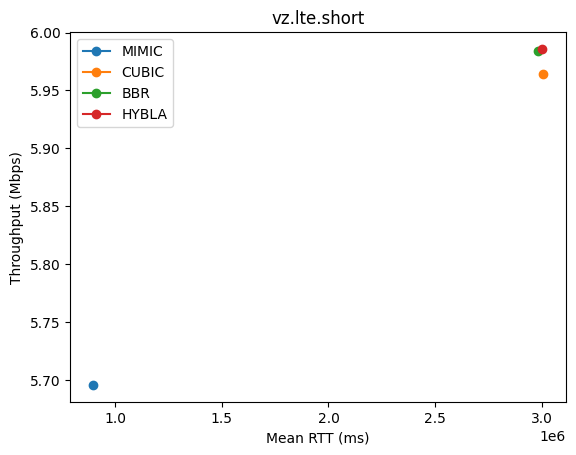

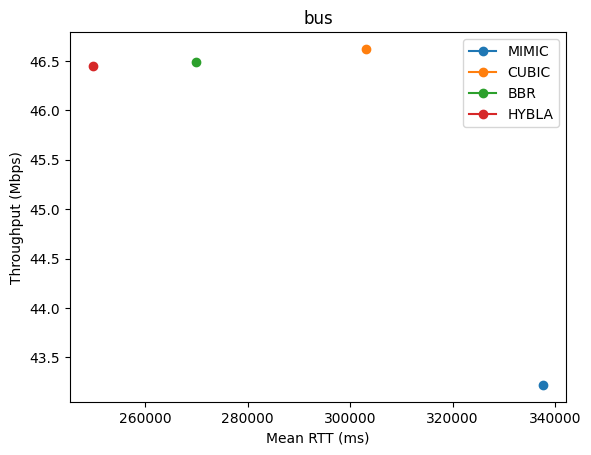

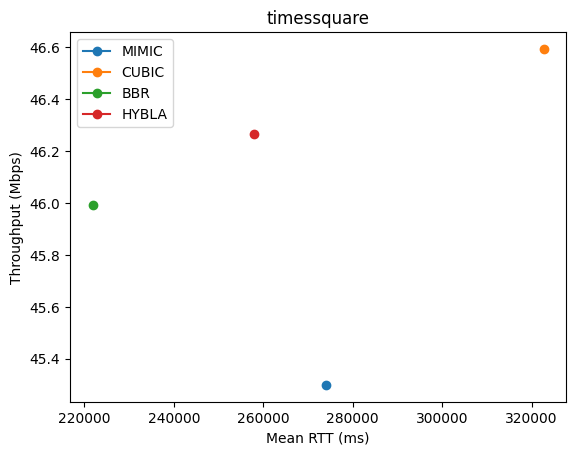

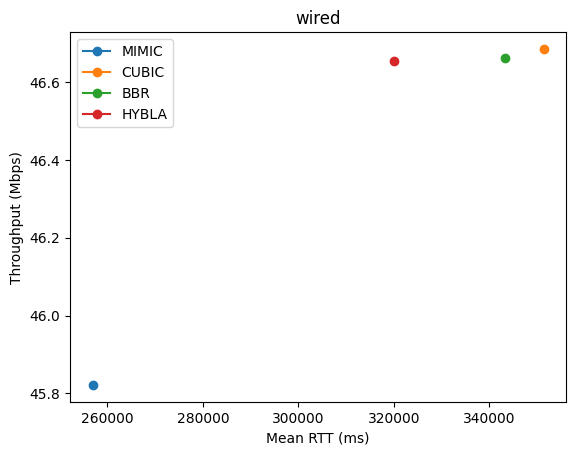

In [6]:
import matplotlib.pyplot as plt
for trace in traces:

    # Get mimic config
    mimic_config = read_json_file(get_config(f"{trace}.{policy}"))

    # Get native prot config
    cubic_config = read_json_file(get_config(f"cubic.{trace}"))
    bbr_config = read_json_file(get_config(f"bbr.{trace}"))
    hybla_config = read_json_file(get_config(f"hybla.{trace}"))

    # Get metrics
    mimic_metrics = mimic_config['end']['streams'][0]['sender']
    cubic_metrics = cubic_config['end']['streams'][0]['sender']
    bbr_metrics = bbr_config['end']['streams'][0]['sender']
    hybla_metrics = hybla_config['end']['streams'][0]['sender']

    #  Get latency
    mimic_min_rtt = mimic_metrics['mean_rtt']
    cubic_min_rtt = cubic_metrics['mean_rtt']
    bbr_min_rtt = bbr_metrics['mean_rtt']
    hybla_min_rtt = hybla_metrics['mean_rtt']

    #  Get thruput
    mimic_thruput = mimic_metrics['bits_per_second']*10**(-6)
    cubic_thruput = cubic_metrics['bits_per_second']*10**(-6)
    bbr_thruput = bbr_metrics['bits_per_second']*10**(-6)
    hybla_thruput = hybla_metrics['bits_per_second']*10**(-6)

    # Plot
    fig, ax = plt.subplots()
    ax.plot(mimic_min_rtt, mimic_thruput, marker='o', label='MIMIC')
    ax.plot(cubic_min_rtt, cubic_thruput, marker='o', label='CUBIC')
    ax.plot(bbr_min_rtt, bbr_thruput, marker='o', label='BBR')
    ax.plot(hybla_min_rtt, hybla_thruput, marker='o', label='HYBLA')

    # set axis labels and legend
    ax.set_title(trace)
    ax.set_xlabel('Mean RTT (ms)')
    ax.set_ylabel('Throughput (Mbps)')
    ax.legend()

    # show plot
    plt.show()
